# Paper Figures: Invariant Δv Planning with Gravity-Gradient Dynamics

This notebook generates all figures for the paper.

## Figure Organization

**Section 6.1: HCW Regime Benchmarks**
- Figure 1: HCW vs invariant trajectory overlay (LVLH x-y)
- Figure 2: Two-impulse Δv comparison (||Δv₀||, ||Δv_T||, Δv_tot)
- Figure 3: Terminal residuals ||ξ_p(T)|| and ||ξ_v(T)||
- Figure 4: Δv vs transfer time sweep
- Figure 5: Conditioning κ(Φ_pv) vs T

**Section 6.2: Thrusting References (LTV Beyond HCW)**
- Figure 6: Reference thrust profile ā(t)
- Figure 7: ||A(t)|| showing LTV behavior
- Figure 8: STM block norms (||Φ_pR||, ||Φ_vR||, ||Φ_pv||)
- Figure 9: Terminal residuals for thrusting cases

**Section 6.3: Attitude Error Sensitivity**
- Figure 10: Δv_tot vs ||ξ_R(0)||
- Figure 11: Contribution breakdown (position, velocity, attitude)
- Figure 12: LVLH vs body-frame Δv comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp
import sys
from pathlib import Path

# Add repo root to path
repo_root = None
for path in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
    if (path / "cp_reach").exists():
        repo_root = path
        break
if repo_root is None:
    raise RuntimeError("Could not locate repo root")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from cp_reach.development.applications.satellite.transfer_dynamics import (
    circular_orbit_gravity_gradient,
    orbital_params_from_radius
)

%matplotlib inline

# Publication-quality settings
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (6, 4)

In [2]:
# =============================================================================
# CORE FUNCTIONS
# =============================================================================

def skew(v):
    """Skew-symmetric matrix [v]_x such that [v]_x @ w = v x w."""
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])


def invariant_A_matrix(omega_bar, a_bar, G):
    """
    Build the 9x9 A matrix for invariant log-linear error dynamics.
    
    From Eq. (7) of the paper:
        A = [[-[ω̄]×,  I,      0     ],
             [G,      -[ω̄]×,  -[ā]× ],
             [0,       0,     -[ω̄]× ]]
    """
    omega_skew = skew(omega_bar)
    a_skew = skew(a_bar)
    I3 = np.eye(3)
    Z3 = np.zeros((3, 3))
    
    A = np.block([
        [-omega_skew, I3,          Z3         ],
        [G,           -omega_skew, -a_skew    ],
        [Z3,          Z3,          -omega_skew]
    ])
    return A


def hcw_A_matrix_6x6(n):
    """
    Build 6x6 HCW A matrix in LVLH coordinates.
    
    The HCW equations in LVLH frame:
        ẍ - 3n²x - 2nẏ = 0
        ÿ + 2nẋ = 0
        z̈ + n²z = 0
    
    State: [r, v] in LVLH (6-dimensional)
    """
    A = np.zeros((6, 6))
    A[0:3, 3:6] = np.eye(3)  # ṙ = v
    A[3, 0] = 3*n**2         # gravity gradient x
    A[5, 2] = -n**2          # gravity gradient z  
    A[3, 4] = 2*n            # Coriolis
    A[4, 3] = -2*n           # Coriolis
    return A


def compute_stm(A_func, T, n_steps=1000):
    """
    Compute state transition matrix by integrating Φ̇ = A(t)Φ.
    
    For LTI systems, this is just expm(A*T).
    For LTV systems, we integrate numerically.
    """
    if not callable(A_func):
        return expm(A_func * T)
    
    # LTV case: numerical integration
    n = A_func(0).shape[0]
    def phi_dot(t, phi_flat):
        Phi = phi_flat.reshape(n, n)
        A = A_func(t)
        return (A @ Phi).flatten()
    
    Phi0 = np.eye(n).flatten()
    sol = solve_ivp(phi_dot, [0, T], Phi0, dense_output=True, rtol=1e-10, atol=1e-12)
    return sol.y[:, -1].reshape(n, n)


def stm_blocks(Phi):
    """Partition 9x9 STM into 3x3 blocks."""
    return {
        'pp': Phi[0:3, 0:3], 'pv': Phi[0:3, 3:6], 'pR': Phi[0:3, 6:9],
        'vp': Phi[3:6, 0:3], 'vv': Phi[3:6, 3:6], 'vR': Phi[3:6, 6:9],
        'Rp': Phi[6:9, 0:3], 'Rv': Phi[6:9, 3:6], 'RR': Phi[6:9, 6:9],
    }


def two_impulse_transfer(xi_0, Phi, R_ref_0=None, R_ref_T=None):
    """
    Compute two-impulse transfer using STM.
    
    Enforces ξ_p(T) = 0 (terminal position targeting).
    """
    if R_ref_0 is None:
        R_ref_0 = np.eye(3)
    if R_ref_T is None:
        R_ref_T = np.eye(3)
    
    xi_p_0 = xi_0[0:3]
    xi_v_0 = xi_0[3:6]
    xi_R_0 = xi_0[6:9]
    
    blocks = stm_blocks(Phi)
    Phi_pp = blocks['pp']
    Phi_pv = blocks['pv']
    Phi_pR = blocks['pR']
    
    # Departure impulse: Δξ_v(0) = -Φ_pv^{-1} (Φ_pp ξ_p(0) + Φ_pR ξ_R(0) + Φ_pv ξ_v(0))
    term_pp = Phi_pp @ xi_p_0
    term_pR = Phi_pR @ xi_R_0
    term_pv = Phi_pv @ xi_v_0
    rhs = term_pp + term_pR + term_pv
    delta_v_0 = -np.linalg.solve(Phi_pv, rhs)
    
    # Post-burn initial condition
    xi_0_plus = xi_0.copy()
    xi_0_plus[3:6] = xi_v_0 + delta_v_0
    
    # Propagate to terminal time
    xi_T_minus = Phi @ xi_0_plus
    xi_v_T_minus = xi_T_minus[3:6]
    
    # Arrival impulse (brake to zero velocity)
    delta_v_T = -xi_v_T_minus
    
    # Map to body frame
    delta_v_0_body = R_ref_0 @ delta_v_0
    delta_v_T_body = R_ref_T @ delta_v_T
    
    # Total cost
    delta_v_total = np.linalg.norm(delta_v_0) + np.linalg.norm(delta_v_T)
    
    return {
        'delta_v_0': delta_v_0,
        'delta_v_T': delta_v_T,
        'delta_v_0_body': delta_v_0_body,
        'delta_v_T_body': delta_v_T_body,
        'delta_v_0_norm': np.linalg.norm(delta_v_0),
        'delta_v_T_norm': np.linalg.norm(delta_v_T),
        'delta_v_total': delta_v_total,
        'xi_0_plus': xi_0_plus,
        'xi_T_minus': xi_T_minus,
        'Phi': Phi,
        'blocks': blocks,
        'term_pp': term_pp,
        'term_pR': term_pR,
        'term_pv': term_pv,
    }


def hcw_two_impulse(r_0, v_0, Phi_hcw):
    """
    Compute two-impulse transfer using HCW STM (6x6).
    
    State: [r, v] in LVLH (6-dimensional)
    """
    Phi_rr = Phi_hcw[0:3, 0:3]
    Phi_rv = Phi_hcw[0:3, 3:6]
    
    # Departure impulse to reach origin at T
    delta_v_0 = -np.linalg.solve(Phi_rv, Phi_rr @ r_0 + Phi_rv @ v_0)
    
    # Post-burn state
    state_0_plus = np.concatenate([r_0, v_0 + delta_v_0])
    state_T = Phi_hcw @ state_0_plus
    
    # Arrival impulse
    delta_v_T = -state_T[3:6]
    
    return {
        'delta_v_0': delta_v_0,
        'delta_v_T': delta_v_T,
        'delta_v_0_norm': np.linalg.norm(delta_v_0),
        'delta_v_T_norm': np.linalg.norm(delta_v_T),
        'delta_v_total': np.linalg.norm(delta_v_0) + np.linalg.norm(delta_v_T),
        'state_0_plus': state_0_plus,
        'state_T': state_T,
    }


def propagate_trajectory(xi_0, A_func, t_span, rtol=1e-10, atol=1e-12):
    """
    Propagate dynamics ξ̇ = A(t)ξ.
    """
    if not callable(A_func):
        A_const = A_func
        A_func = lambda t: A_const
    
    def dynamics(t, xi):
        return A_func(t) @ xi
    
    sol = solve_ivp(dynamics, [t_span[0], t_span[-1]], xi_0,
                    t_eval=t_span, rtol=rtol, atol=atol)
    return sol.y.T


def rotation_matrix_z(angle):
    """Rotation matrix about z-axis."""
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

In [3]:
# =============================================================================
# PROBLEM SETUP
# =============================================================================

# Orbital parameters (LEO circular orbit)
mu = 3.986e14  # Earth gravitational parameter (m³/s²)
r_orbit = 6.771e6  # Orbital radius (m) - ~400 km altitude

params = orbital_params_from_radius(r_orbit, mu)
n = params['n']  # Mean motion (rad/s)
T_orbit = params['T_orbit']  # Orbital period (s)

# Gravity gradient tensors
# True tidal tensor: G_tidal = n² diag([2, -1, -1])
# HCW effective:     G_eff   = n² diag([3, 0, -1])  (includes centrifugal)
G_tidal = np.diag([2*n**2, -n**2, -n**2])  # True gravity gradient for invariant
G_eff = circular_orbit_gravity_gradient(n)  # HCW uses this
G = G_tidal  # Use G_tidal for invariant formulation

# Reference angular velocity (circular orbit)
Omega = np.array([0.0, 0.0, n])

# Rendezvous scenario
r_0_lvlh = np.array([100.0, -50.0, 0.0])  # Position in LVLH (m)
v_0_lvlh = np.array([0.0, 0.0, 0.0])      # Velocity in LVLH (m/s) - at rest

# Transform to invariant coordinates
xi_p_0 = r_0_lvlh
xi_v_0 = v_0_lvlh + np.cross(Omega, xi_p_0)  # v_LVLH = ξ_v - Ω×ξ_p
xi_R_0 = np.array([0.0, 0.0, 0.0])           # Zero attitude error
xi_0 = np.concatenate([xi_p_0, xi_v_0, xi_R_0])

# Transfer time: half orbit
T_transfer = 0.5 * T_orbit

# Coasting reference (no thrust)
a_bar_coast = np.array([0.0, 0.0, 0.0])

# Build A matrices
A_inv = invariant_A_matrix(Omega, a_bar_coast, G)
A_hcw = hcw_A_matrix_6x6(n)

print(f"Orbital Parameters:")
print(f"  Radius: {r_orbit/1e6:.3f} km")
print(f"  Period: {T_orbit/60:.1f} min")
print(f"  Mean motion n: {n:.6e} rad/s")
print(f"\nRendezvous Scenario:")
print(f"  Initial position: {r_0_lvlh} m")
print(f"  Transfer time: {T_transfer/60:.1f} min ({T_transfer/T_orbit:.2f} orbits)")

Orbital Parameters:
  Radius: 6.771 km
  Period: 92.4 min
  Mean motion n: 1.133155e-03 rad/s

Rendezvous Scenario:
  Initial position: [100. -50.   0.] m
  Transfer time: 46.2 min (0.50 orbits)


In [4]:
# =============================================================================
# COMPUTE SOLUTIONS FOR HCW REGIME
# =============================================================================

# Compute STMs
Phi_inv = compute_stm(A_inv, T_transfer)  # 9x9 invariant
Phi_hcw = compute_stm(A_hcw, T_transfer)  # 6x6 HCW

# Solve using invariant method
result_inv = two_impulse_transfer(xi_0, Phi_inv)

# Solve using HCW method (in LVLH coordinates)
result_hcw = hcw_two_impulse(r_0_lvlh, v_0_lvlh, Phi_hcw)

# Simulate trajectories
t_eval = np.linspace(0, T_transfer, 500)
xi_traj_inv = propagate_trajectory(result_inv['xi_0_plus'], A_inv, t_eval)
state_traj_hcw = propagate_trajectory(result_hcw['state_0_plus'], A_hcw, t_eval)

print("HCW vs Invariant Comparison:")
print(f"  Invariant Total Δv: {result_inv['delta_v_total']:.6f} m/s")
print(f"  HCW Total Δv:       {result_hcw['delta_v_total']:.6f} m/s")
print(f"  Difference:         {abs(result_inv['delta_v_total'] - result_hcw['delta_v_total']):.2e} m/s")

HCW vs Invariant Comparison:
  Invariant Total Δv: 0.299903 m/s
  HCW Total Δv:       0.299903 m/s
  Difference:         4.44e-16 m/s


---
# Section 6.1: HCW Regime Benchmarks
---

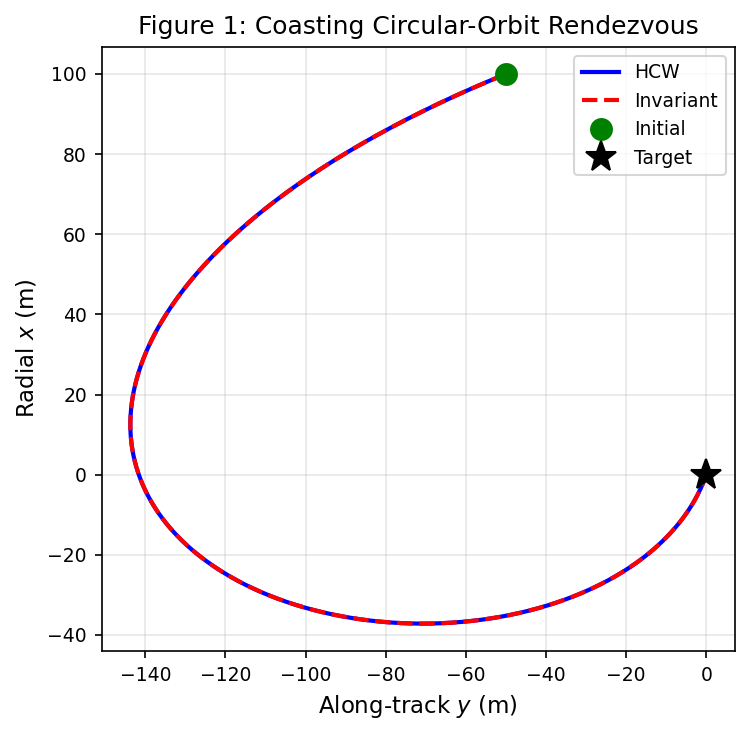

In [5]:
# =============================================================================
# FIGURE 1: HCW vs Invariant Trajectory Overlay
# =============================================================================

fig, ax = plt.subplots(figsize=(6, 5))

# HCW trajectory
ax.plot(state_traj_hcw[:, 1], state_traj_hcw[:, 0], 'b-', linewidth=2, label='HCW')
# Invariant trajectory (position is ξ_p)
ax.plot(xi_traj_inv[:, 1], xi_traj_inv[:, 0], 'r--', linewidth=2, label='Invariant')

# Start and end markers
ax.plot(r_0_lvlh[1], r_0_lvlh[0], 'go', markersize=10, label='Initial', zorder=5)
ax.plot(0, 0, 'k*', markersize=15, label='Target', zorder=5)

ax.set_xlabel('Along-track $y$ (m)')
ax.set_ylabel('Radial $x$ (m)')
ax.set_title('Figure 1: Coasting Circular-Orbit Rendezvous')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('fig01_trajectory_overlay.pdf', bbox_inches='tight')
plt.savefig('fig01_trajectory_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

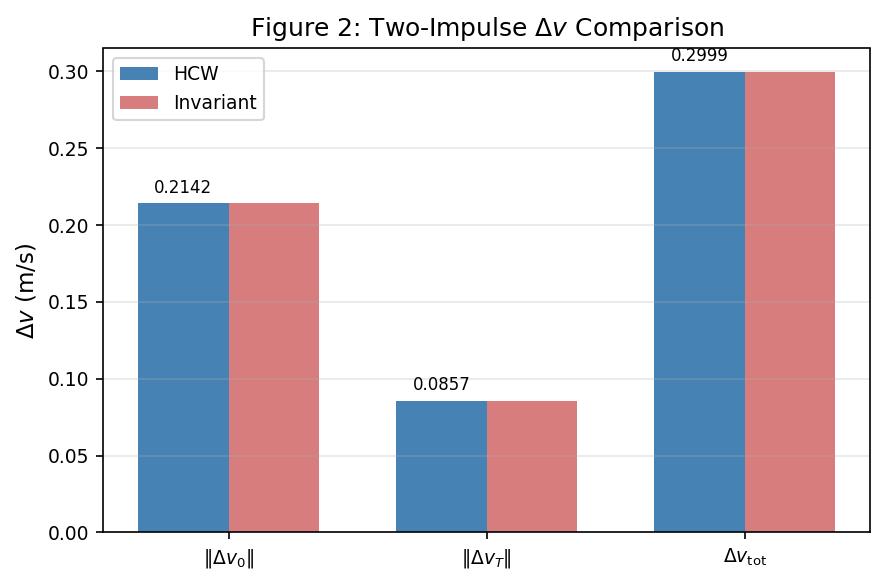

Exact values:
  HCW:       ||Δv₀|| = 0.214174, ||Δv_T|| = 0.085729, Total = 0.299903 m/s
  Invariant: ||Δv₀|| = 0.214174, ||Δv_T|| = 0.085729, Total = 0.299903 m/s


In [6]:
# =============================================================================
# FIGURE 2: Two-Impulse Δv Comparison
# =============================================================================

fig, ax = plt.subplots(figsize=(6, 4))

# Data for bar plot
labels = ['$\\|\\Delta v_0\\|$', '$\\|\\Delta v_T\\|$', '$\\Delta v_{\\mathrm{tot}}$']
hcw_vals = [result_hcw['delta_v_0_norm'], result_hcw['delta_v_T_norm'], result_hcw['delta_v_total']]
inv_vals = [result_inv['delta_v_0_norm'], result_inv['delta_v_T_norm'], result_inv['delta_v_total']]

x = np.arange(len(labels))
width = 0.35

bars1 = ax.bar(x - width/2, hcw_vals, width, label='HCW', color='steelblue')
bars2 = ax.bar(x + width/2, inv_vals, width, label='Invariant', color='indianred', alpha=0.8)

ax.set_ylabel('$\\Delta v$ (m/s)')
ax.set_title('Figure 2: Two-Impulse $\\Delta v$ Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('fig02_deltav_comparison.pdf', bbox_inches='tight')
plt.savefig('fig02_deltav_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print exact values
print("Exact values:")
print(f"  HCW:       ||Δv₀|| = {result_hcw['delta_v_0_norm']:.6f}, ||Δv_T|| = {result_hcw['delta_v_T_norm']:.6f}, Total = {result_hcw['delta_v_total']:.6f} m/s")
print(f"  Invariant: ||Δv₀|| = {result_inv['delta_v_0_norm']:.6f}, ||Δv_T|| = {result_inv['delta_v_T_norm']:.6f}, Total = {result_inv['delta_v_total']:.6f} m/s")

In [7]:
# =============================================================================
# FIGURE 3: Terminal Residuals
# =============================================================================

# Compute terminal residuals for both methods
xi_p_T_inv = result_inv['xi_T_minus'][0:3]
xi_v_T_inv = result_inv['xi_T_minus'][3:6] + result_inv['delta_v_T']  # After braking

r_T_hcw = result_hcw['state_T'][0:3]
v_T_hcw = result_hcw['state_T'][3:6] + result_hcw['delta_v_T']  # After braking

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Position residuals
ax = axes[0]
labels = ['HCW', 'Invariant']
pos_residuals = [np.linalg.norm(r_T_hcw), np.linalg.norm(xi_p_T_inv)]
colors = ['steelblue', 'indianred']
ax.bar(labels, pos_residuals, color=colors)
ax.set_ylabel('$\\|\\xi_p(T)\\|$ (m)')
ax.set_title('Position Residual')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pos_residuals):
    ax.text(i, v*1.5, f'{v:.2e}', ha='center', fontsize=9)

# Velocity residuals
ax = axes[1]
vel_residuals = [np.linalg.norm(v_T_hcw), np.linalg.norm(xi_v_T_inv)]
ax.bar(labels, vel_residuals, color=colors)
ax.set_ylabel('$\\|\\xi_v(T^+)\\|$ (m/s)')
ax.set_title('Velocity Residual (after braking)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(vel_residuals):
    ax.text(i, v*1.5, f'{v:.2e}', ha='center', fontsize=9)

fig.suptitle('Figure 3: Terminal Residuals (Coasting HCW Regime)', y=1.02)
plt.tight_layout()
plt.savefig('fig03_terminal_residuals.pdf', bbox_inches='tight')
plt.savefig('fig03_terminal_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_171211/966774979.py:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_171211/966774979.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


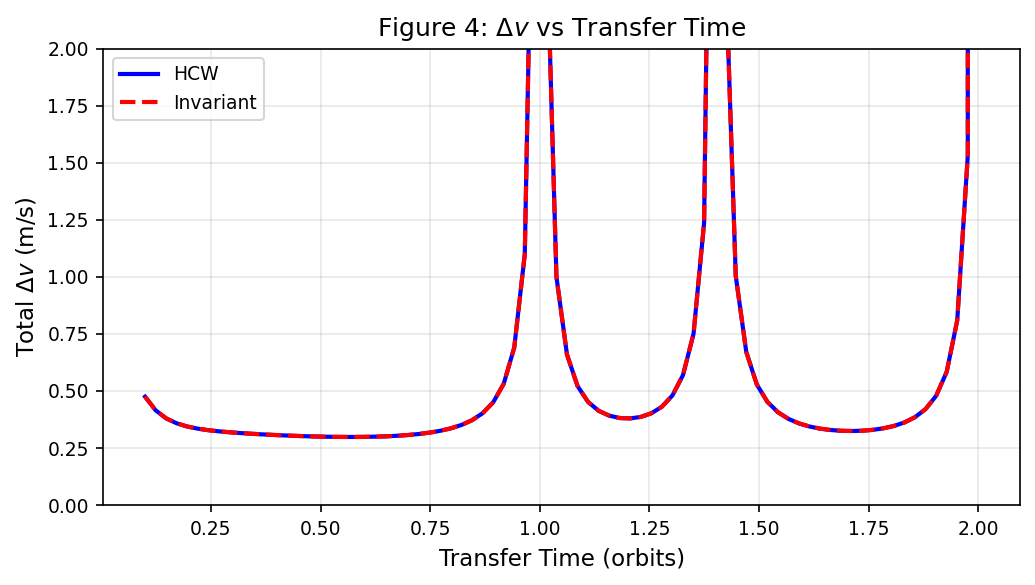

In [8]:
# =============================================================================
# FIGURE 4: Δv vs Transfer Time Sweep
# =============================================================================

# Sweep transfer times from 0.1 to 2 orbits
T_fractions = np.linspace(0.1, 2.0, 80)
T_values = T_fractions * T_orbit

delta_v_inv_sweep = []
delta_v_hcw_sweep = []

for T in T_values:
    # Invariant
    try:
        Phi = compute_stm(A_inv, T)
        result = two_impulse_transfer(xi_0, Phi)
        delta_v_inv_sweep.append(result['delta_v_total'])
    except:
        delta_v_inv_sweep.append(np.nan)
    
    # HCW
    try:
        Phi_h = compute_stm(A_hcw, T)
        result_h = hcw_two_impulse(r_0_lvlh, v_0_lvlh, Phi_h)
        delta_v_hcw_sweep.append(result_h['delta_v_total'])
    except:
        delta_v_hcw_sweep.append(np.nan)

delta_v_inv_sweep = np.array(delta_v_inv_sweep)
delta_v_hcw_sweep = np.array(delta_v_hcw_sweep)

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(T_fractions, delta_v_hcw_sweep, 'b-', linewidth=2, label='HCW')
ax.plot(T_fractions, delta_v_inv_sweep, 'r--', linewidth=2, label='Invariant')

ax.set_xlabel('Transfer Time (orbits)')
ax.set_ylabel('Total $\\Delta v$ (m/s)')
ax.set_title('Figure 4: $\\Delta v$ vs Transfer Time')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, min(2.0, np.nanmax(delta_v_hcw_sweep)*1.1)])

plt.tight_layout()
plt.savefig('fig04_deltav_vs_time.pdf', bbox_inches='tight')
plt.savefig('fig04_deltav_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()

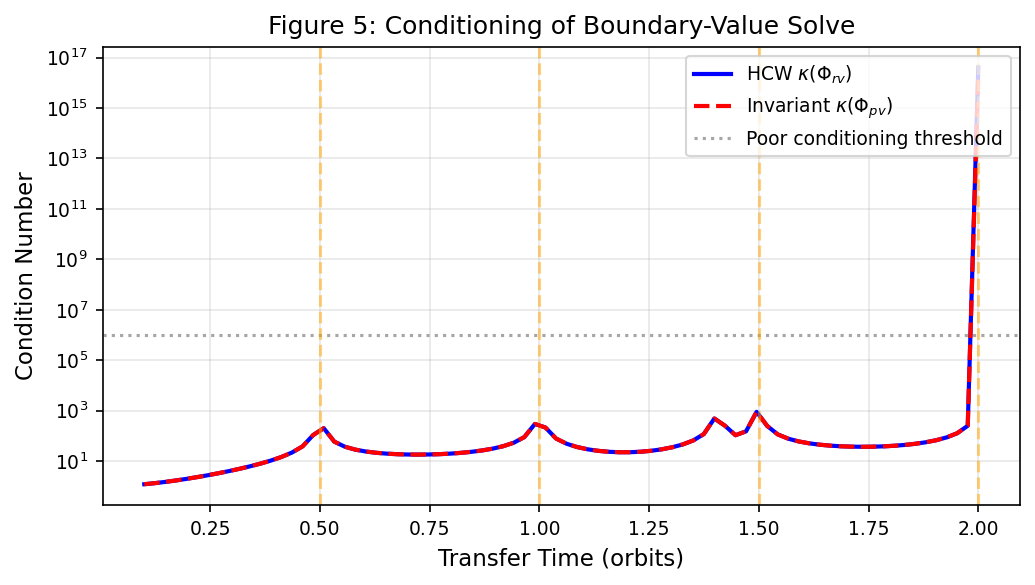

In [9]:
# =============================================================================
# FIGURE 5: Conditioning κ(Φ_pv) vs Transfer Time
# =============================================================================

phi_pv_cond_inv = []
phi_rv_cond_hcw = []

for T in T_values:
    # Invariant
    Phi = compute_stm(A_inv, T)
    blocks = stm_blocks(Phi)
    phi_pv_cond_inv.append(np.linalg.cond(blocks['pv']))
    
    # HCW
    Phi_h = compute_stm(A_hcw, T)
    phi_rv_cond_hcw.append(np.linalg.cond(Phi_h[0:3, 3:6]))

phi_pv_cond_inv = np.array(phi_pv_cond_inv)
phi_rv_cond_hcw = np.array(phi_rv_cond_hcw)

fig, ax = plt.subplots(figsize=(7, 4))

ax.semilogy(T_fractions, phi_rv_cond_hcw, 'b-', linewidth=2, label='HCW $\\kappa(\\Phi_{rv})$')
ax.semilogy(T_fractions, phi_pv_cond_inv, 'r--', linewidth=2, label='Invariant $\\kappa(\\Phi_{pv})$')
ax.axhline(1e6, color='gray', linestyle=':', alpha=0.7, label='Poor conditioning threshold')

# Mark integer orbit multiples (where z-singularity occurs)
for orbit_frac in [0.5, 1.0, 1.5, 2.0]:
    ax.axvline(orbit_frac, color='orange', linestyle='--', alpha=0.5)

ax.set_xlabel('Transfer Time (orbits)')
ax.set_ylabel('Condition Number')
ax.set_title('Figure 5: Conditioning of Boundary-Value Solve')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig05_conditioning.pdf', bbox_inches='tight')
plt.savefig('fig05_conditioning.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Section 6.2: Thrusting References (LTV Beyond HCW)
---

In [10]:
# =============================================================================
# THRUSTING REFERENCE SETUP
# =============================================================================

# Define thrust profiles
a_max = 0.002  # 2 mm/s² peak thrust
T_burn = T_transfer / 4  # Burn duration

def a_bar_ramp(t):
    """Ramped thrust profile: linear ramp up, then off."""
    if t < T_burn:
        return np.array([a_max * t / T_burn, 0.0, 0.0])
    else:
        return np.array([0.0, 0.0, 0.0])

def a_bar_constant(t):
    """Constant thrust profile during burn phase."""
    if t < T_burn:
        return np.array([a_max, 0.0, 0.0])
    else:
        return np.array([0.0, 0.0, 0.0])

def A_time_varying_ramp(t):
    """Time-varying A matrix with ramped thrust."""
    return invariant_A_matrix(Omega, a_bar_ramp(t), G)

def A_time_varying_const(t):
    """Time-varying A matrix with constant thrust."""
    return invariant_A_matrix(Omega, a_bar_constant(t), G)

# Compute STM for thrusting case
print("Computing STM for thrusting reference...")
Phi_thrust = compute_stm(A_time_varying_const, T_transfer, n_steps=2000)
result_thrust = two_impulse_transfer(xi_0, Phi_thrust)
print(f"Done. Thrust Δv_tot = {result_thrust['delta_v_total']:.6f} m/s")

Computing STM for thrusting reference...
Done. Thrust Δv_tot = 0.299903 m/s


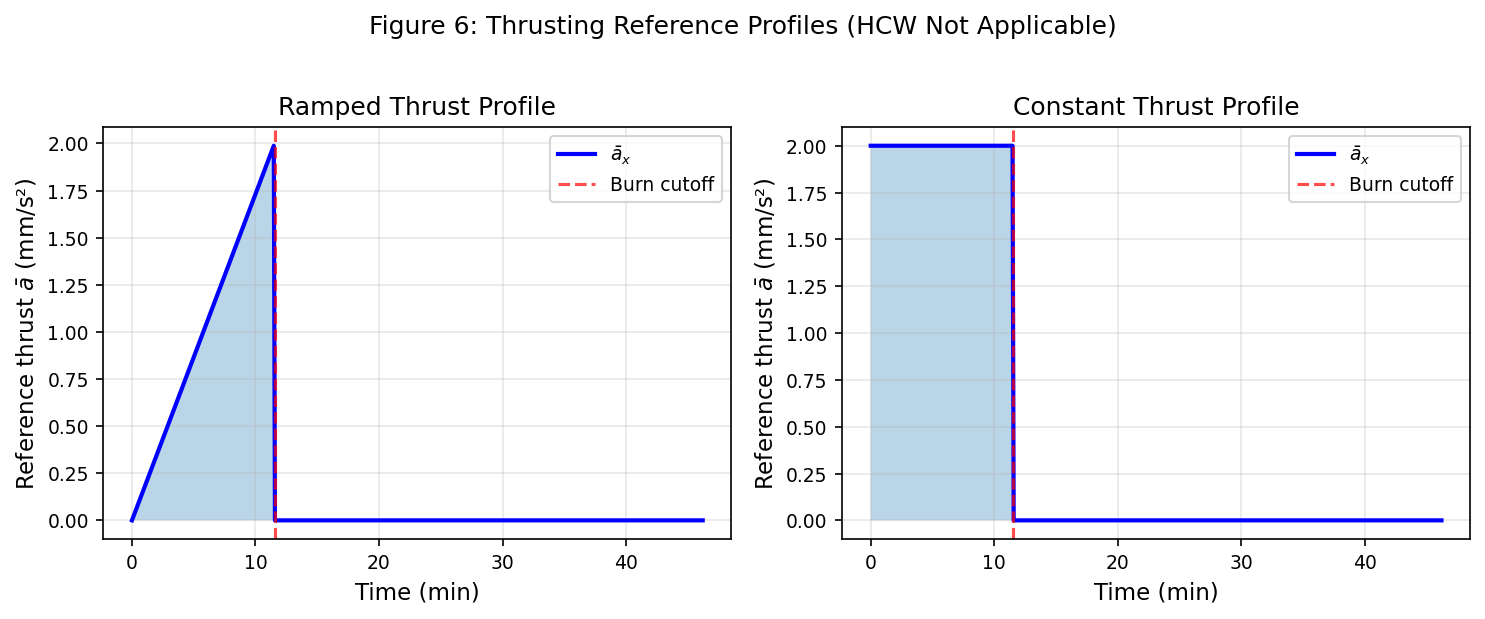

In [11]:
# =============================================================================
# FIGURE 6: Reference Thrust Profile
# =============================================================================

t_plot = np.linspace(0, T_transfer, 500)
a_ramp_profile = np.array([a_bar_ramp(t) for t in t_plot])
a_const_profile = np.array([a_bar_constant(t) for t in t_plot])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Ramped thrust
ax = axes[0]
ax.plot(t_plot/60, a_ramp_profile[:, 0]*1000, 'b-', linewidth=2, label='$\\bar{a}_x$')
ax.fill_between(t_plot/60, 0, a_ramp_profile[:, 0]*1000, alpha=0.3)
ax.axvline(T_burn/60, color='r', linestyle='--', alpha=0.7, label='Burn cutoff')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Reference thrust $\\bar{a}$ (mm/s²)')
ax.set_title('Ramped Thrust Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# Constant thrust
ax = axes[1]
ax.plot(t_plot/60, a_const_profile[:, 0]*1000, 'b-', linewidth=2, label='$\\bar{a}_x$')
ax.fill_between(t_plot/60, 0, a_const_profile[:, 0]*1000, alpha=0.3)
ax.axvline(T_burn/60, color='r', linestyle='--', alpha=0.7, label='Burn cutoff')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Reference thrust $\\bar{a}$ (mm/s²)')
ax.set_title('Constant Thrust Profile')
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle('Figure 6: Thrusting Reference Profiles (HCW Not Applicable)', y=1.02)
plt.tight_layout()
plt.savefig('fig06_thrust_profile.pdf', bbox_inches='tight')
plt.savefig('fig06_thrust_profile.png', dpi=300, bbox_inches='tight')
plt.show()

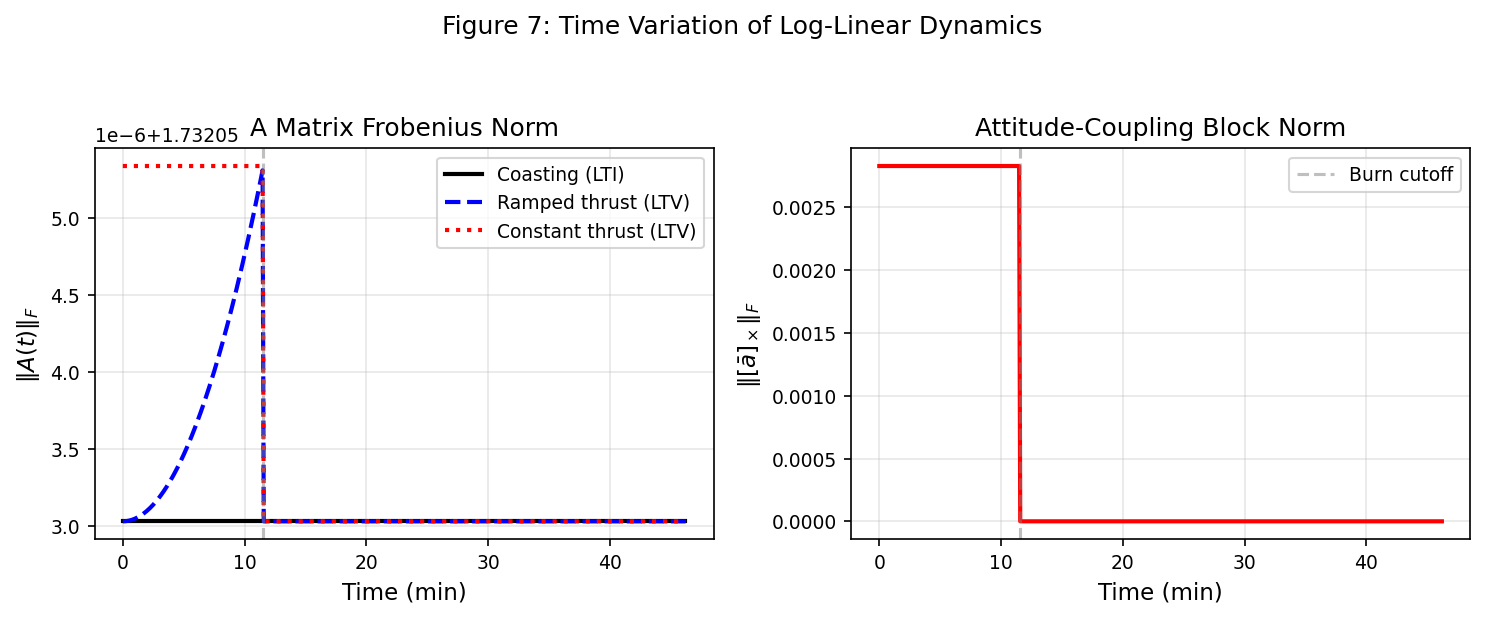

In [12]:
# =============================================================================
# FIGURE 7: ||A(t)|| Showing LTV Behavior
# =============================================================================

A_norms_ramp = []
A_norms_const = []
A_norms_coast = []
a_skew_norms = []

for t in t_plot:
    A_r = A_time_varying_ramp(t)
    A_c = A_time_varying_const(t)
    A_norms_ramp.append(np.linalg.norm(A_r))
    A_norms_const.append(np.linalg.norm(A_c))
    A_norms_coast.append(np.linalg.norm(A_inv))  # Constant for coasting
    # Track the thrust-dependent block
    a_skew_norms.append(np.linalg.norm(A_c[3:6, 6:9]))  # -[ā]× block

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ||A(t)|| comparison
ax = axes[0]
ax.plot(t_plot/60, A_norms_coast, 'k-', linewidth=2, label='Coasting (LTI)')
ax.plot(t_plot/60, A_norms_ramp, 'b--', linewidth=2, label='Ramped thrust (LTV)')
ax.plot(t_plot/60, A_norms_const, 'r:', linewidth=2, label='Constant thrust (LTV)')
ax.axvline(T_burn/60, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (min)')
ax.set_ylabel('$\\|A(t)\\|_F$')
ax.set_title('A Matrix Frobenius Norm')
ax.legend()
ax.grid(True, alpha=0.3)

# Thrust-dependent block
ax = axes[1]
ax.plot(t_plot/60, a_skew_norms, 'r-', linewidth=2)
ax.axvline(T_burn/60, color='gray', linestyle='--', alpha=0.5, label='Burn cutoff')
ax.set_xlabel('Time (min)')
ax.set_ylabel('$\\|[\\bar{a}]_\\times\\|_F$')
ax.set_title('Attitude-Coupling Block Norm')
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle('Figure 7: Time Variation of Log-Linear Dynamics', y=1.02)
plt.tight_layout()
plt.savefig('fig07_A_matrix_variation.pdf', bbox_inches='tight')
plt.savefig('fig07_A_matrix_variation.png', dpi=300, bbox_inches='tight')
plt.show()

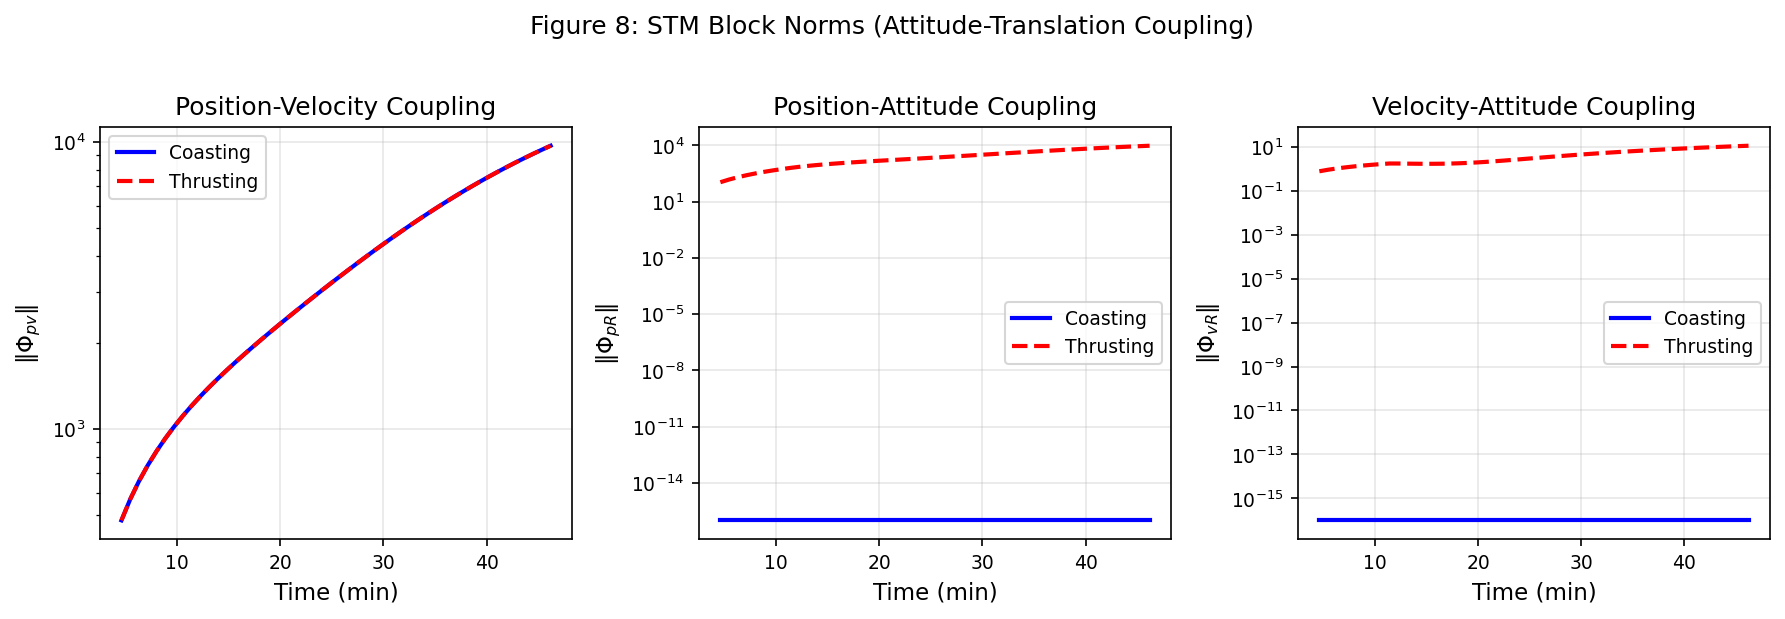


At T = 46.2 min:
  Coasting: ||Φ_pR|| = 0.00e+00
  Thrusting: ||Φ_pR|| = 9.49e+03


In [13]:
# =============================================================================
# FIGURE 8: STM Block Norms
# =============================================================================

T_sweep = np.linspace(0.05*T_orbit, T_transfer, 50)

# For coasting (LTI)
phi_pv_norms_coast = []
phi_pR_norms_coast = []
phi_vR_norms_coast = []

# For thrusting (LTV)
phi_pv_norms_thrust = []
phi_pR_norms_thrust = []
phi_vR_norms_thrust = []

for T in T_sweep:
    # Coasting
    Phi_c = compute_stm(A_inv, T)
    blocks_c = stm_blocks(Phi_c)
    phi_pv_norms_coast.append(np.linalg.norm(blocks_c['pv']))
    phi_pR_norms_coast.append(np.linalg.norm(blocks_c['pR']))
    phi_vR_norms_coast.append(np.linalg.norm(blocks_c['vR']))
    
    # Thrusting
    Phi_t = compute_stm(A_time_varying_const, T, n_steps=1000)
    blocks_t = stm_blocks(Phi_t)
    phi_pv_norms_thrust.append(np.linalg.norm(blocks_t['pv']))
    phi_pR_norms_thrust.append(np.linalg.norm(blocks_t['pR']))
    phi_vR_norms_thrust.append(np.linalg.norm(blocks_t['vR']))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# ||Φ_pv||
ax = axes[0]
ax.semilogy(T_sweep/60, phi_pv_norms_coast, 'b-', linewidth=2, label='Coasting')
ax.semilogy(T_sweep/60, phi_pv_norms_thrust, 'r--', linewidth=2, label='Thrusting')
ax.set_xlabel('Time (min)')
ax.set_ylabel('$\\|\\Phi_{pv}\\|$')
ax.set_title('Position-Velocity Coupling')
ax.legend()
ax.grid(True, alpha=0.3)

# ||Φ_pR||
ax = axes[1]
ax.semilogy(T_sweep/60, np.maximum(phi_pR_norms_coast, 1e-16), 'b-', linewidth=2, label='Coasting')
ax.semilogy(T_sweep/60, np.maximum(phi_pR_norms_thrust, 1e-16), 'r--', linewidth=2, label='Thrusting')
ax.set_xlabel('Time (min)')
ax.set_ylabel('$\\|\\Phi_{pR}\\|$')
ax.set_title('Position-Attitude Coupling')
ax.legend()
ax.grid(True, alpha=0.3)

# ||Φ_vR||
ax = axes[2]
ax.semilogy(T_sweep/60, np.maximum(phi_vR_norms_coast, 1e-16), 'b-', linewidth=2, label='Coasting')
ax.semilogy(T_sweep/60, np.maximum(phi_vR_norms_thrust, 1e-16), 'r--', linewidth=2, label='Thrusting')
ax.set_xlabel('Time (min)')
ax.set_ylabel('$\\|\\Phi_{vR}\\|$')
ax.set_title('Velocity-Attitude Coupling')
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle('Figure 8: STM Block Norms (Attitude-Translation Coupling)', y=1.02)
plt.tight_layout()
plt.savefig('fig08_stm_blocks.pdf', bbox_inches='tight')
plt.savefig('fig08_stm_blocks.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAt T = {T_transfer/60:.1f} min:")
print(f"  Coasting: ||Φ_pR|| = {phi_pR_norms_coast[-1]:.2e}")
print(f"  Thrusting: ||Φ_pR|| = {phi_pR_norms_thrust[-1]:.2e}")

In [14]:
# =============================================================================
# FIGURE 9: Terminal Residuals for Thrusting Cases
# =============================================================================

# Compute terminal residuals for thrusting case
xi_p_T_thrust = result_thrust['xi_T_minus'][0:3]
xi_v_T_thrust = result_thrust['xi_T_minus'][3:6] + result_thrust['delta_v_T']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Position residuals
ax = axes[0]
labels = ['Coasting', 'Thrusting']
pos_residuals = [np.linalg.norm(xi_p_T_inv), np.linalg.norm(xi_p_T_thrust)]
colors = ['steelblue', 'indianred']
ax.bar(labels, pos_residuals, color=colors)
ax.set_ylabel('$\\|\\xi_p(T)\\|$ (m)')
ax.set_title('Position Residual')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pos_residuals):
    ax.text(i, v*2, f'{v:.2e}', ha='center', fontsize=9)

# Velocity residuals
ax = axes[1]
vel_residuals = [np.linalg.norm(xi_v_T_inv), np.linalg.norm(xi_v_T_thrust)]
ax.bar(labels, vel_residuals, color=colors)
ax.set_ylabel('$\\|\\xi_v(T^+)\\|$ (m/s)')
ax.set_title('Velocity Residual (after braking)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(vel_residuals):
    ax.text(i, v*2, f'{v:.2e}', ha='center', fontsize=9)

fig.suptitle('Figure 9: Terminal Residuals (Coasting vs Thrusting Reference)', y=1.02)
plt.tight_layout()
plt.savefig('fig09_terminal_residuals_thrust.pdf', bbox_inches='tight')
plt.savefig('fig09_terminal_residuals_thrust.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_171211/3584873670.py:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_171211/3584873670.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


---
# Section 6.3: Attitude Error Sensitivity
---

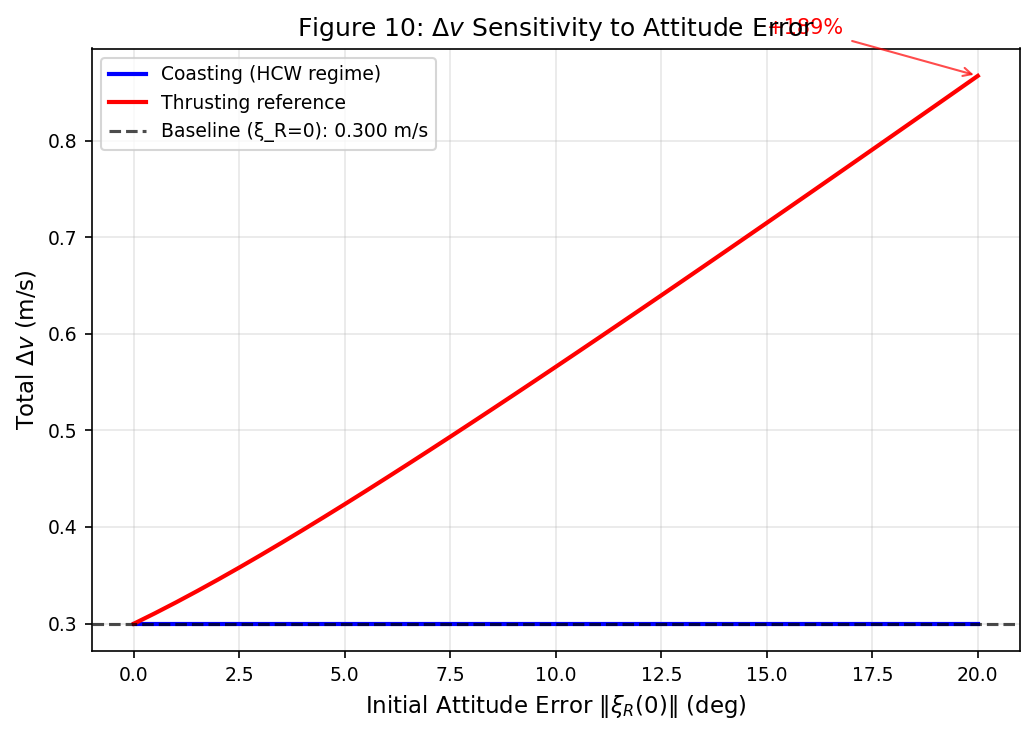


At 20° attitude error (thrusting):
  Δv = 0.8670 m/s (+189% from baseline)


In [15]:
# =============================================================================
# FIGURE 10: Δv vs Attitude Error Magnitude
# =============================================================================

# Sweep attitude error magnitude
att_errors_deg = np.linspace(0, 20, 41)
att_errors_rad = np.deg2rad(att_errors_deg)

delta_v_vs_att_thrust = []
delta_v_vs_att_coast = []

for att_err in att_errors_rad:
    # Attitude error about z-axis (yaw)
    xi_R_test = np.array([0.0, 0.0, att_err])
    xi_0_test = np.concatenate([xi_p_0, xi_v_0, xi_R_test])
    
    # Thrusting case
    result_t = two_impulse_transfer(xi_0_test, Phi_thrust)
    delta_v_vs_att_thrust.append(result_t['delta_v_total'])
    
    # Coasting case (for comparison)
    result_c = two_impulse_transfer(xi_0_test, Phi_inv)
    delta_v_vs_att_coast.append(result_c['delta_v_total'])

delta_v_vs_att_thrust = np.array(delta_v_vs_att_thrust)
delta_v_vs_att_coast = np.array(delta_v_vs_att_coast)

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(att_errors_deg, delta_v_vs_att_coast, 'b-', linewidth=2, label='Coasting (HCW regime)')
ax.plot(att_errors_deg, delta_v_vs_att_thrust, 'r-', linewidth=2, label='Thrusting reference')
ax.axhline(result_inv['delta_v_total'], color='k', linestyle='--', alpha=0.7,
           label=f'Baseline (ξ_R=0): {result_inv["delta_v_total"]:.3f} m/s')

ax.set_xlabel('Initial Attitude Error $\\|\\xi_R(0)\\|$ (deg)')
ax.set_ylabel('Total $\\Delta v$ (m/s)')
ax.set_title('Figure 10: $\\Delta v$ Sensitivity to Attitude Error')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Annotate the increase
pct_increase = (delta_v_vs_att_thrust[-1] / delta_v_vs_att_thrust[0] - 1) * 100
ax.annotate(f'+{pct_increase:.0f}%', 
            xy=(20, delta_v_vs_att_thrust[-1]), 
            xytext=(15, delta_v_vs_att_thrust[-1]*1.05),
            fontsize=10, color='red',
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

plt.tight_layout()
plt.savefig('fig10_deltav_vs_attitude.pdf', bbox_inches='tight')
plt.savefig('fig10_deltav_vs_attitude.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAt 20° attitude error (thrusting):")
print(f"  Δv = {delta_v_vs_att_thrust[-1]:.4f} m/s (+{pct_increase:.0f}% from baseline)")

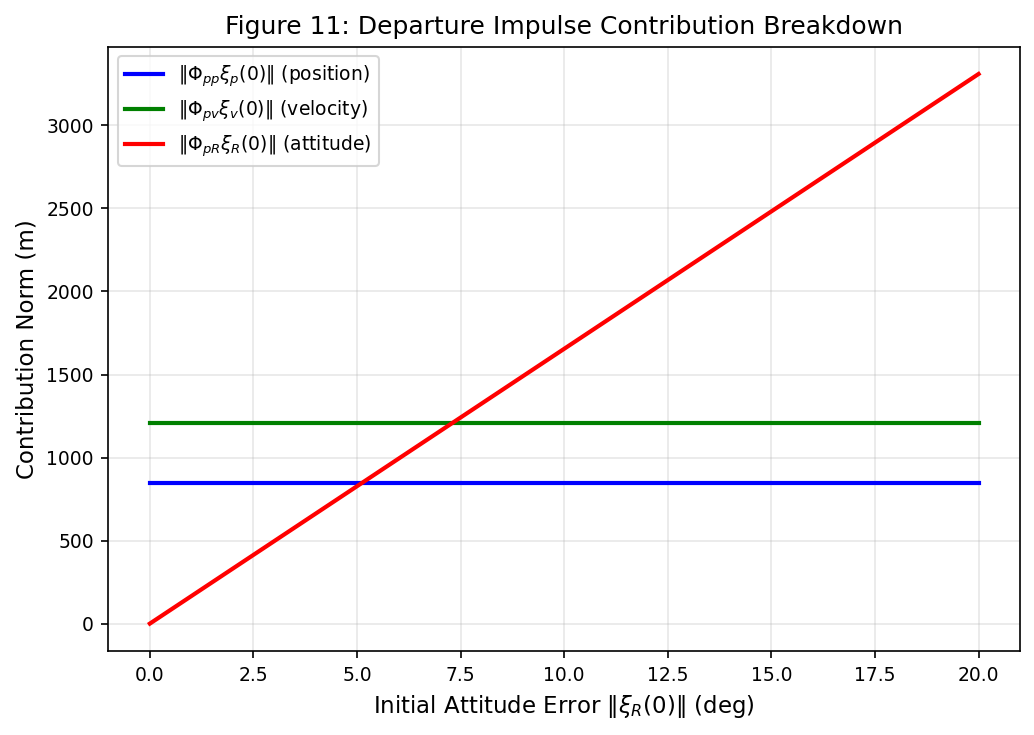

In [16]:
# =============================================================================
# FIGURE 11: Contribution Breakdown
# =============================================================================

term_pp_norms = []
term_pv_norms = []
term_pR_norms = []

for att_err in att_errors_rad:
    xi_R_test = np.array([0.0, 0.0, att_err])
    xi_0_test = np.concatenate([xi_p_0, xi_v_0, xi_R_test])
    
    result = two_impulse_transfer(xi_0_test, Phi_thrust)
    term_pp_norms.append(np.linalg.norm(result['term_pp']))
    term_pv_norms.append(np.linalg.norm(result['term_pv']))
    term_pR_norms.append(np.linalg.norm(result['term_pR']))

term_pp_norms = np.array(term_pp_norms)
term_pv_norms = np.array(term_pv_norms)
term_pR_norms = np.array(term_pR_norms)

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(att_errors_deg, term_pp_norms, 'b-', linewidth=2, label='$\\|\\Phi_{pp}\\xi_p(0)\\|$ (position)')
ax.plot(att_errors_deg, term_pv_norms, 'g-', linewidth=2, label='$\\|\\Phi_{pv}\\xi_v(0)\\|$ (velocity)')
ax.plot(att_errors_deg, term_pR_norms, 'r-', linewidth=2, label='$\\|\\Phi_{pR}\\xi_R(0)\\|$ (attitude)')

ax.set_xlabel('Initial Attitude Error $\\|\\xi_R(0)\\|$ (deg)')
ax.set_ylabel('Contribution Norm (m)')
ax.set_title('Figure 11: Departure Impulse Contribution Breakdown')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig11_contribution_breakdown.pdf', bbox_inches='tight')
plt.savefig('fig11_contribution_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

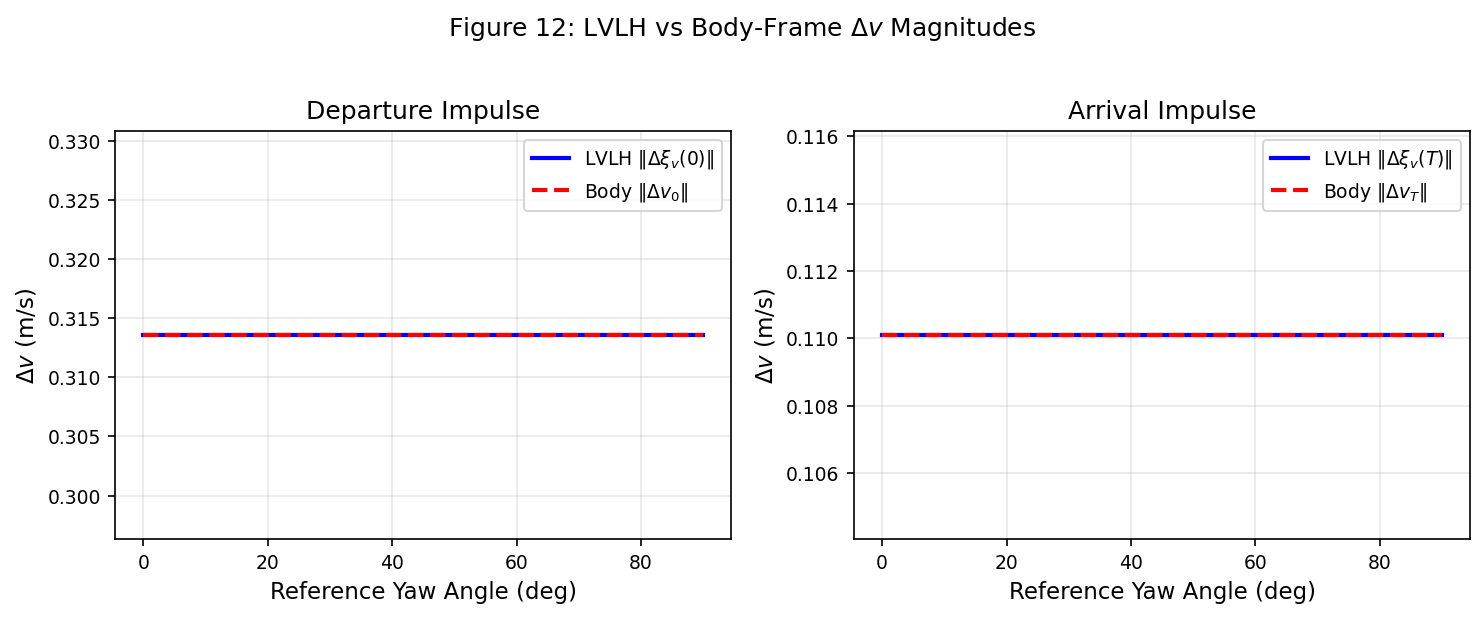


Note: Magnitudes are equal (rotation preserves norm).
Direction matters for thruster allocation and pointing constraints.


In [17]:
# =============================================================================
# FIGURE 12: LVLH vs Body-Frame Δv
# =============================================================================

# Vary reference attitude at burn time
yaw_angles_deg = np.linspace(0, 90, 37)
yaw_angles_rad = np.deg2rad(yaw_angles_deg)

dv0_lvlh_norms = []
dv0_body_norms = []
dvT_lvlh_norms = []
dvT_body_norms = []

# Use thrusting case with small attitude error
xi_R_small = np.array([0.0, 0.0, np.deg2rad(5)])  # 5 deg attitude error
xi_0_att = np.concatenate([xi_p_0, xi_v_0, xi_R_small])

for yaw in yaw_angles_rad:
    R_ref_0 = rotation_matrix_z(yaw)
    R_ref_T = rotation_matrix_z(yaw + n * T_transfer)  # Rotates with orbit
    
    result = two_impulse_transfer(xi_0_att, Phi_thrust, R_ref_0=R_ref_0, R_ref_T=R_ref_T)
    
    # LVLH (invariant) Δv
    dv0_lvlh_norms.append(np.linalg.norm(result['delta_v_0']))
    dvT_lvlh_norms.append(np.linalg.norm(result['delta_v_T']))
    
    # Body-frame Δv
    dv0_body_norms.append(np.linalg.norm(result['delta_v_0_body']))
    dvT_body_norms.append(np.linalg.norm(result['delta_v_T_body']))

dv0_lvlh_norms = np.array(dv0_lvlh_norms)
dv0_body_norms = np.array(dv0_body_norms)
dvT_lvlh_norms = np.array(dvT_lvlh_norms)
dvT_body_norms = np.array(dvT_body_norms)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Departure impulse
ax = axes[0]
ax.plot(yaw_angles_deg, dv0_lvlh_norms, 'b-', linewidth=2, label='LVLH $\\|\\Delta\\xi_v(0)\\|$')
ax.plot(yaw_angles_deg, dv0_body_norms, 'r--', linewidth=2, label='Body $\\|\\Delta v_0\\|$')
ax.set_xlabel('Reference Yaw Angle (deg)')
ax.set_ylabel('$\\Delta v$ (m/s)')
ax.set_title('Departure Impulse')
ax.legend()
ax.grid(True, alpha=0.3)

# Arrival impulse
ax = axes[1]
ax.plot(yaw_angles_deg, dvT_lvlh_norms, 'b-', linewidth=2, label='LVLH $\\|\\Delta\\xi_v(T)\\|$')
ax.plot(yaw_angles_deg, dvT_body_norms, 'r--', linewidth=2, label='Body $\\|\\Delta v_T\\|$')
ax.set_xlabel('Reference Yaw Angle (deg)')
ax.set_ylabel('$\\Delta v$ (m/s)')
ax.set_title('Arrival Impulse')
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle('Figure 12: LVLH vs Body-Frame $\\Delta v$ Magnitudes', y=1.02)
plt.tight_layout()
plt.savefig('fig12_lvlh_vs_body.pdf', bbox_inches='tight')
plt.savefig('fig12_lvlh_vs_body.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNote: Magnitudes are equal (rotation preserves norm).")
print("Direction matters for thruster allocation and pointing constraints.")

---
# Summary Table
---

In [18]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================

print("=" * 80)
print("                              SUMMARY TABLE")
print("=" * 80)
print(f"{'Scenario':<50} {'Δv (m/s)':<12} {'Notes'}")
print("-" * 80)
print(f"{'HCW (coasting, LVLH)':<50} {result_hcw['delta_v_total']:<12.6f} Reference")
print(f"{'Invariant (coasting, ξ_R=0)':<50} {result_inv['delta_v_total']:<12.6f} Matches HCW exactly")
print(f"{'Invariant (thrust, ξ_R=0)':<50} {result_thrust['delta_v_total']:<12.6f} HCW N/A")
print(f"{'Invariant (thrust, ξ_R=5°)':<50} {delta_v_vs_att_thrust[10]:<12.6f} Attitude coupling")
print(f"{'Invariant (thrust, ξ_R=20°)':<50} {delta_v_vs_att_thrust[-1]:<12.6f} +{pct_increase:.0f}% from attitude")
print("=" * 80)

# Verify HCW match
diff = abs(result_inv['delta_v_total'] - result_hcw['delta_v_total'])
print(f"\nHCW vs Invariant difference: {diff:.2e} m/s")
if diff < 1e-9:
    print("  -> EXACT MATCH (within numerical tolerance)")

                              SUMMARY TABLE
Scenario                                           Δv (m/s)     Notes
--------------------------------------------------------------------------------
HCW (coasting, LVLH)                               0.299903     Reference
Invariant (coasting, ξ_R=0)                        0.299903     Matches HCW exactly
Invariant (thrust, ξ_R=0)                          0.299903     HCW N/A
Invariant (thrust, ξ_R=5°)                         0.423674     Attitude coupling
Invariant (thrust, ξ_R=20°)                        0.866972     +189% from attitude

HCW vs Invariant difference: 4.44e-16 m/s
  -> EXACT MATCH (within numerical tolerance)


In [19]:
# List all generated figures
import os
print("\nGenerated figure files:")
for f in sorted(os.listdir('.')):
    if f.startswith('fig') and (f.endswith('.pdf') or f.endswith('.png')):
        print(f"  {f}")


Generated figure files:
  fig01_trajectory_overlay.pdf
  fig01_trajectory_overlay.png
  fig02_deltav_comparison.pdf
  fig02_deltav_comparison.png
  fig03_terminal_residuals.pdf
  fig03_terminal_residuals.png
  fig04_deltav_vs_time.pdf
  fig04_deltav_vs_time.png
  fig05_conditioning.pdf
  fig05_conditioning.png
  fig06_thrust_profile.pdf
  fig06_thrust_profile.png
  fig07_A_matrix_variation.pdf
  fig07_A_matrix_variation.png
  fig08_stm_blocks.pdf
  fig08_stm_blocks.png
  fig09_terminal_residuals_thrust.pdf
  fig09_terminal_residuals_thrust.png
  fig10_deltav_vs_attitude.pdf
  fig10_deltav_vs_attitude.png
  fig11_contribution_breakdown.pdf
  fig11_contribution_breakdown.png
  fig12_lvlh_vs_body.pdf
  fig12_lvlh_vs_body.png
  fig1_comparison.png
  fig1_hcw_match.png
  fig2_deltav_sweep.png
  fig3_thrusting_reference.png
  fig5_attitude_coupling.png
  fig6_lvlh_vs_body.png
